In [1]:
import torch
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
import zuko

In [2]:
mu = 42
N = 50000
prior_over_mu = torch.distributions.Normal(torch.Tensor([0.0]), torch.Tensor([25.0]))

Utils

In [3]:
def true_data_generating_process():
    dist = torch.distributions.Normal(mu, 1.0)
    return dist.sample((100, ))

def computing_summary(data):
    sample_mean = torch.mean(data)
    sample.var = torch.var(data)
    return sample_mean,  sample_var


Simulation (line 1 & 2 of Algorithm 1)

In [21]:
def simulator(mu):
    dist = torch.distributions.Normal(mu, 2.0)
    sample = dist.sample((100, ))
    sample_mean = torch.mean(sample)
    sample_var = torch.var(sample)
    return sample_mean, sample_var


def simulate():
    thetas_vect = torch.zeros((N, 1))
    X_vect = torch.zeros((N, 2))
    for i in range(N):
        theta_i = prior_over_mu.sample((1, ))
        x_i = simulator(theta_i)
        thetas_vect[i] = theta_i
        X_vect[i][0], X_vect[i][1] = x_i

    thetas_test = torch.zeros((N//10, 1))
    x_test = torch.zeros((N//10, 2))  
    for i in range(N//10):
        theta_i_test = prior_over_mu.sample((1, ))
        x_i_test = simulator(theta_i_test)
        thetas_test[i] = theta_i_test
        x_test[i][0], X_vect[i][1] = x_i_test
    return X_vect, thetas_vect, x_test, thetas_test
X_vect,thetas_vect, x_test, thetas_test = simulate()

In [5]:
#flowjax.bijections.transformers import RationalQuadraticSplineTransformer # No jax available ... 

Train NPE q(theta|x) on the simulated dataset {(thetai, xi)}, i=1, ... N
Uses a neural spline flow defining the transform on the interval [-5, 5] using 10  spline segments and 5 coupling layers. The base of the flow is a standard Gaussian distribution. 

In [ ]:

q_NPE = zuko.flows.NSF(1,2, hidden_features=[5]*1) #TODO Essayer de comprendre comment il est crée pck là ...
q_NPE = zuko.flows.NSF(features=1, context=2, bins=10, transforms=5)

In [90]:
#Creates the dataset & loaded
dataset = TensorDataset(thetas_vect, X_vect)
batch_size = 256
loader = DataLoader(dataset,batch_size,shuffle=True)
#Param for training
max_epochs = 50
learning_rate_NSF = 5*10e-4
epsilon = 1e-3
#Optim
optimizer = torch.optim.Adam(q_NPE.parameters(), learning_rate_NSF)
#Preparing for ealry stop
with torch.no_grad():
    previous_loss = -q_NPE(x_test).log_prob(thetas_test).mean()
counter=1
patience = 5

#Training
for epoch in range(max_epochs):
    print(f" Epoch = {epoch+1}")
    
    for batch_idx, batch in enumerate(loader):
        thetas_batch, x_batch = batch
        loss = -q_NPE(x_batch).log_prob(thetas_batch).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Checking for improvment
    with torch.no_grad():
        loss_test = -q_NPE(x_test).log_prob(thetas_test).mean()
        if np.abs(loss_test - previous_loss) < epsilon:
            counter += 1
        if counter == patience:
            print(f"Early stop at iteration {i}")
            break
        previous_loss = loss_test
    print(f"Loss on the validation set = {previous_loss}")

 Epoch = 1
Loss on the validation set = 321.25640869140625
 Epoch = 2
Loss on the validation set = 321.30230712890625
 Epoch = 3
Loss on the validation set = 321.2463684082031
 Epoch = 4
Loss on the validation set = 321.22113037109375
 Epoch = 5
Loss on the validation set = 321.2651062011719
 Epoch = 6
Loss on the validation set = 321.23114013671875
 Epoch = 7
Loss on the validation set = 321.2898864746094
 Epoch = 8
Loss on the validation set = 321.2662048339844
 Epoch = 9
Loss on the validation set = 321.3302001953125
 Epoch = 10
Loss on the validation set = 321.24847412109375
 Epoch = 11
Loss on the validation set = 321.3004150390625
 Epoch = 12
Loss on the validation set = 321.323486328125
 Epoch = 13
Loss on the validation set = 321.347412109375
 Epoch = 14
Loss on the validation set = 321.32318115234375
 Epoch = 15
Loss on the validation set = 321.335205078125
 Epoch = 16
Loss on the validation set = 321.3681945800781
 Epoch = 17
Loss on the validation set = 321.3880920410156
 Ep

Train q(x) on {xi} i=1, ... N (so first gen the x)
For q(x) uses of a block neural autoregressive flow, single hidden layer of size 8D, x in R^d

In [91]:
def simu_x():
    
    x = torch.zeros((N, 2))
    for i in range(N):
        theta_tmp = prior_over_mu.sample((1, ))
        xi = simulator(theta_tmp)
        x[i][0], x[i][1] = xi
    # {xi} i=1, ... N 
    xtest = torch.zeros((N//10, 2))
    for i in range(N//10):
        theta_tmp = prior_over_mu.sample((1, ))
        xtest[i][0], xtest[i][1] =  simulator(theta_tmp)
        return x, x_test
x, x_test = simu_x()
        


In [92]:
#Preparaing dataset & loader
dataset = TensorDataset(x)
batch_size = 256
loader = DataLoader(dataset,batch_size,shuffle=True)

q_x = ??? #Pas trouvé dans le package encore. 

#Training param
max_epochs = 50
learning_rate_BNAF = 10-2
epsilon = 1e-5
#Optim
optimizer = torch.optim.Adam(q_x.parameters(), learning_rate_BNAF)
#Early stop
with torch.no_grad():
    previous_loss = -q_x.log_prob(x_test).mean()
counter=1
patience = 5
#Training

for epoch in range(max_epochs):
    print(f" Epoch = {epoch+1}")
    
    for batch_idx, batch in enumerate(loader):
        thetas_batch, x_batch = batch
        loss = -q_x.log_prob(x_test).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        loss_test = -q_x.log_prob(x_test).mean()
        if np.abs(loss_test - previous_loss) < epsilon:
            counter += 1
        if counter == patience:
            print(f"Early stop at iteration {i}")
            break
        previous_loss = loss_test
    print(f"Loss on the validation set = {previous_loss}")

SyntaxError: invalid syntax (1279069519.py, line 6)

Sample x~m from p(x | y0) % p(y0 \ x) q(x), m = 1, ... M using MCMC

Spike and slab

In [ ]:
def error_model(y, x):
    """Spike and slab model, computing p(y | x)

    Args:
        y (torch.Tensor): An observation
        x (torch.Tensor): A context sampled from q(x)

    Returns:
        float: p(y | x)
    """
    rho = 0.5
    sigma = 0.01
    tau =0.25
    res = 1.0
    D = x.size()[0]
    for j in range(D):
        dist_normal = torch.distributions.Normal(torch.Tensor([x[j]]), torch.Tensor([sigma]))
        dist_cauchy = torch.distributions.Cauchy(torch.Tensor([x[j]]), tau)
        well_specified_part = (1 - rho) * torch.exp(dist_normal.log_prob(y[j]))
        miss_specified_part = rho * torch.exp(dist_cauchy.log_prob(y[j]))
        res = res * (well_specified_part + miss_specified_part)
        return res

In [ ]:
M = 100000
warm_up_steps = 20000
traj_lenght = 1
target_acceptance_prob = 0.95

Il faut aussi faire les 2 autres simu cad NPE (comme avant) et en mettant directement le modele d'erreur dans le simu

In [ ]:
def noisy_simulator():
    #Sample the parameters theta [mu]
    sigma = 0.01
    tau = 0.25
    rho = 1/2
    X, thetas, X_test, thetas_test = simulate()
    res_train, res_test = X.clone(), X_test.clone()
    D = X[0].size()[0]
    for i, x in enumerate(X):
        spike_dist = torch.distributions.Normal(x, torch.Tensor([sigma]))
        slab_dist = torch.distributions.Cauchy(x, torch.Tensor([tau]))
        spike = ((1 - rho) *spike_dist.sample((1, )))[0]
        slab = (rho * slab_dist.sample((1, )))[0]
        res_train[i] += spike + slab
    for i, x in enumerate(X_test):
        spike_dist = torch.distributions.Normal(x, torch.Tensor([sigma]))
        slab_dist = torch.distributions.Cauchy(x, torch.Tensor([tau]))
        spike = ((1 - rho) *spike_dist.sample((1, )))[0]
        slab = (rho * slab_dist.sample((1, )))[0]
        res_test[i] += spike + slab
    return res_train, thetas, res_test, thetas_test
        

In [ ]:
X_noisy, thetas, X_noisy_test, thetas_test = noisy_simulator()

In [ ]:
q_NPE_noisy = zuko.flows.NSF(1,2, hidden_features=[5]*1) 


In [ ]:
#Creates the dataset & loaded
dataset = TensorDataset(thetas_vect, X_noisy)
batch_size = 256
loader = DataLoader(dataset,batch_size,shuffle=True)
#Param for training
max_epochs = 50
learning_rate_NSF = 5*10e-4
epsilon = 1e-3
#Optim
optimizer = torch.optim.Adam(q_NPE_noisy.parameters(), learning_rate_NSF)
#Preparing for ealry stop
with torch.no_grad():
    previous_loss = -q_NPE_noisy(X_noisy_test).log_prob(thetas_test).mean()
counter=1
patience = 5
losses = []
#Training
for epoch in range(max_epochs):
    print(f" Epoch = {epoch+1}")
    losses_epoch = 0
    for batch_idx, batch in enumerate(loader):
        
        thetas_batch, x_batch = batch
        loss = -q_NPE_noisy(x_batch).log_prob(thetas_batch).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses_epoch += loss.detach().item()
    losses.append(losses_epoch)
    # Checking for improvment
    with torch.no_grad():
        loss_test = -q_NPE_noisy(X_noisy_test).log_prob(thetas_test).mean()
        if np.abs(loss_test - previous_loss) < epsilon:
            counter += 1
        if counter == patience:
            print(f"Early stop at epoch {epoch}")
            break
        previous_loss = loss_test
    print(f"Loss on the validation set = {previous_loss}")

 Epoch = 1
Loss on the validation set = 318.62860107421875
 Epoch = 2
Loss on the validation set = 318.6251525878906
 Epoch = 3
Loss on the validation set = 318.6268615722656
 Epoch = 4
Loss on the validation set = 318.6279602050781
 Epoch = 5
Loss on the validation set = 318.63140869140625
 Epoch = 6
Loss on the validation set = 318.6331481933594
 Epoch = 7
Loss on the validation set = 318.6296691894531
 Epoch = 8
Loss on the validation set = 318.631103515625
 Epoch = 9
Loss on the validation set = 318.629150390625
 Epoch = 10
Loss on the validation set = 318.629150390625
 Epoch = 11
Loss on the validation set = 318.63250732421875
 Epoch = 12
Loss on the validation set = 318.63116455078125
 Epoch = 13
Loss on the validation set = 318.6278381347656
 Epoch = 14
Loss on the validation set = 318.6295471191406
 Epoch = 15
Loss on the validation set = 318.6308288574219
 Epoch = 16
Loss on the validation set = 318.62908935546875
 Epoch = 17
Loss on the validation set = 318.6271057128906
 Epo

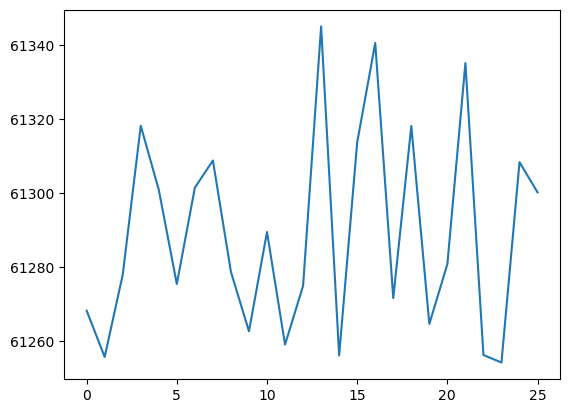

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)